# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the Surveys

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0,sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert Columns to Numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense Datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine Datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find Correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting Survey Correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt

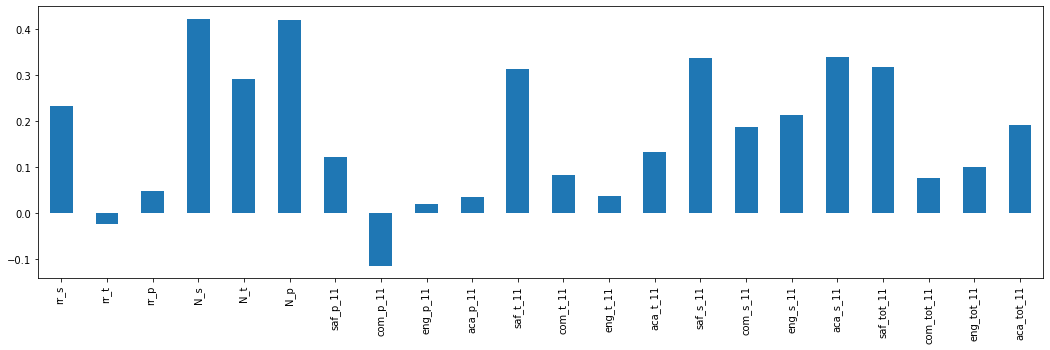

In [12]:
plt.figure(figsize=(18,5))
correlations[survey_fields].plot.bar()

We can see from the above chart that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlates highly with sat_score. Next, We'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.

# Exploring Safety and SAT scores

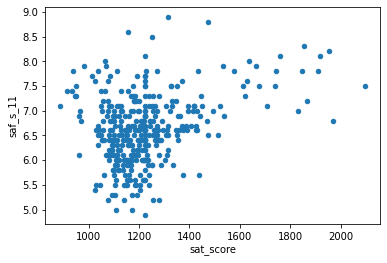

In [13]:
combined.plot.scatter(x='sat_score',y='saf_s_11')

The relation tends to a postive correlation but not a very strong one. There seems to be a cluster between SAT scores 1000 - 1300 which is what is causing the high correlation. 

In [28]:
score_by_dist=combined.groupby(['school_dist'])['sat_score'].mean()

In [29]:
score_by_dist

school_dist
01    1354.500000
02    1295.638184
03    1293.443035
04    1224.142857
05    1285.062687
06    1164.643881
07    1128.846154
08    1159.665129
09    1131.971940
10    1222.227273
11    1165.000000
12    1101.823134
13    1237.187600
14    1179.459915
15    1190.604312
16    1120.109701
17    1161.428571
18    1118.000000
19    1103.833333
20    1273.687761
21    1206.312619
22    1450.500000
23    1157.333333
24    1242.000000
25    1357.000000
26    1377.600000
27    1224.300000
28    1347.846947
29    1181.929851
30    1326.382090
31    1382.500000
32    1119.500000
Name: sat_score, dtype: float64

# Exploring RACE and SAT scores

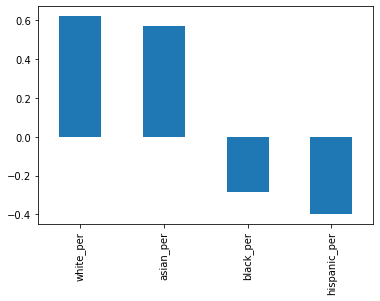

In [30]:
race=['white_per','asian_per','black_per','hispanic_per']
correlations[race].plot.bar()

We can see a strong positive correlation between sat scores and schools with a high percentage of white and asian students. Conversely, students with predominantly black/hispanic population have a strong negative correlation with SAT scores. This may be due to lack of funding for schools that are in areas with hispanic/black communities.   

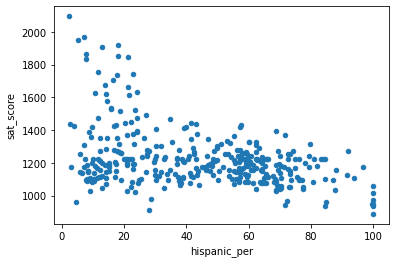

In [31]:
combined.plot.scatter(x='hispanic_per',y='sat_score')

We can see a strong negative correlation between SAT scores and schools with high % of hispanic students.High SAT scores of >1600 are seen from schools that have lower than 20% hispanic students whereas schools where 50% of the students are hispanic average around 1200 in SAT scores. 

In [43]:
combined.loc[(combined['hispanic_per']<10) | (combined['hispanic_per']>95),['SCHOOL NAME','hispanic_per','sat_score']].sort_values(by='hispanic_per')

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.000000
235,MEDGAR EVERS COLLEGE PREPARATORY SCHOOL,2.8,1436.000000
331,PATHWAYS COLLEGE PREPARATORY SCHOOL: A COLLEGE...,2.9,1173.000000
46,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,4.0,1424.000000
237,IT TAKES A VILLAGE ACADEMY,4.5,963.000000
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.000000
236,CLARA BARTON HIGH SCHOOL,5.8,1251.000000
241,VICTORY COLLEGIATE HIGH SCHOOL,5.8,1143.000000
223,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,6.7,1139.000000
192,BEDFORD ACADEMY HIGH SCHOOL,7.1,1312.000000


The schools with a high hispanic population appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores. Many of the schools with a lower hispanic populaiton seem to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Exploring Gender and SAT scores

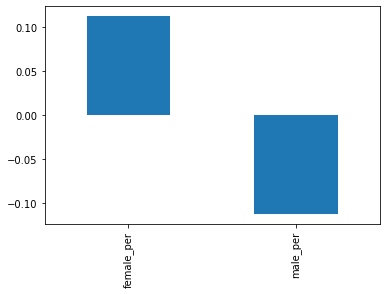

In [71]:
correlations[['female_per','male_per']].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

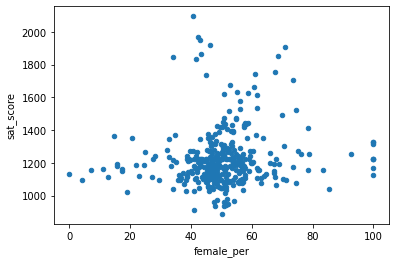

In [72]:
combined.plot.scatter(x='female_per',y='sat_score')


Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [63]:
combined.loc[(combined['female_per']>60) & (combined['sat_score']>1700),['SCHOOL NAME','female_per','sat_score']].sort_values(by='female_per')

,SCHOOL NAME,female_per,sat_score
60,BEACON HIGH SCHOOL,61.0,1744.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0


These schools appears to be very selective liberal arts schools that have high academic standards.

# Exploring AP Scores vs SAT scores

In [73]:
combined['ap_per']=(combined['AP Test Takers ']/combined['total_enrollment'])*100

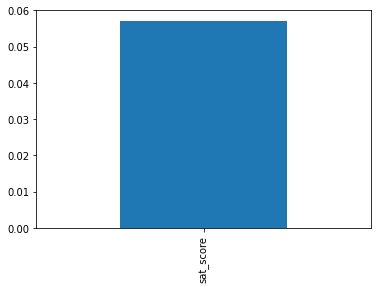

In [82]:
combined.corr()['ap_per'][['sat_score']].plot.bar()

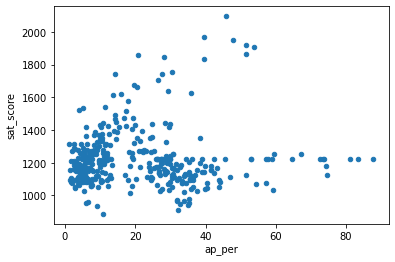

In [83]:
combined.plot.scatter(x='ap_per',y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.